# <div align='center'> 分类任务测试 </div>

In [1]:
%reload_ext autoreload
%autoreload 2

In [59]:
backbones = [
    'resnet18',           # 0
    'resnet50',           # 1
    'densenet121',        # 2
    'mobilenet_v2',       # 3
    'squeezenet1_0',      # 4
    'squeezenet1_1',      # 5
    'shufflenet_v2_x0_5', # 6
    'shufflenet_v2_x1_0', # 7
]

batch_sizes = [8, 16, 32, 64]
input_sizes = [28, 32, 64, 128, 256]

In [60]:
from k12libs.utils.nb_easy import k12ai_run_project

project = k12ai_run_project(
    debug=True, tb_port=9002,
    framework='k12cv', task='cls', 
    network=backbones[0], dataset='rDogsVsCats')

Box(children=(Box(children=(VBox(children=(Tab(children=(VBox(children=(HBox(children=(Text(value='cls', conti…

## Nude Codes

In [34]:
import os
import json
import torch
import PIL.Image as Image
from torchvision import datasets, transforms 
from torchvision.models import vgg16_bn as VGG16
from torch.utils.data import (Dataset, DataLoader)
from k12libs.utils.nb_easy import k12ai_start_html, k12ai_get_top_dir, K12AI_DATASETS_ROOT, K12AI_PRETRAINED_ROOT

### Dataset Loader

In [12]:
class DogCatDataset(Dataset):
    data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'dogsVsCats')
    
    def __init__(self, phase):
        self.images, self.labels = self.data_reader(self.data_root, phase)
    
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        img_trans = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
        ])

        return img_trans(img), self.labels[index]

    def __len__(self):
        return len(self.images)
    
    def data_reader(self, path, phase):
        image_list = []
        label_list = []

        with open(os.path.join(path, f'{phase}.json'), 'r') as f:
            items = json.load(f)
            for item in items:
                image_list.append(os.path.join(path, item['image_path']))
                label_list.append(item['label'])
        return image_list, label_list
    
train_dataloader = DataLoader(DogCatDataset('train'), batch_size=64, shuffle=True)
valid_dataloader = DataLoader(DogCatDataset('val'), batch_size=64, shuffle=False)
test_dataloader = DataLoader(DogCatDataset('test'), batch_size=64, shuffle=False)

In [30]:
len(train_dataloader), len(test_dataloader)

(254, 40)

### Model

In [18]:
model = VGG16(pretrained=True)
model.classifier[6] = torch.nn.Linear(4096, 2)

### Loss,Optimizer

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

### Train

In [ ]:
model.cuda()
max_epoch = 1

train_accs = []
for i in range(max_epoch):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_accs.append((outputs.argmax(dim=1) == targets).float().mean())
        if batch_idx % 30 == 0:
            print(i, train_accs[-1])

In [28]:
sum(train_accs) / len(train_accs)

tensor(1., device='cuda:0')

### Valid or Test

In [37]:
test_accs = []
model.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(valid_dataloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        test_accs.append((outputs.argmax(dim=1) == targets).float().mean())
        if batch_idx % 10 == 0:
            print(i, test_accs[-1])
sum(test_accs) / len(test_accs)

0 tensor(1., device='cuda:0')
0 tensor(0.9844, device='cuda:0')
0 tensor(0.9844, device='cuda:0')


tensor(0.9930, device='cuda:0')

### Save

In [38]:
ckpt_path = os.path.join(K12AI_PRETRAINED_ROOT, 'cv', 'k12lite', 'model_vgg16_bn_dogcat.pth')
torch.save(model.state_dict(), ckpt_path)

### Predict

In [41]:
cat_image = os.path.join(k12ai_get_top_dir(), 'assets', 'images', 'cat-1.jpg')
dog_image = os.path.join(k12ai_get_top_dir(), 'assets', 'images', 'dog-1.jpeg')

! ls {cat_image}

/hzcsk12/hzcsnote/assets/images/cat-1.jpg


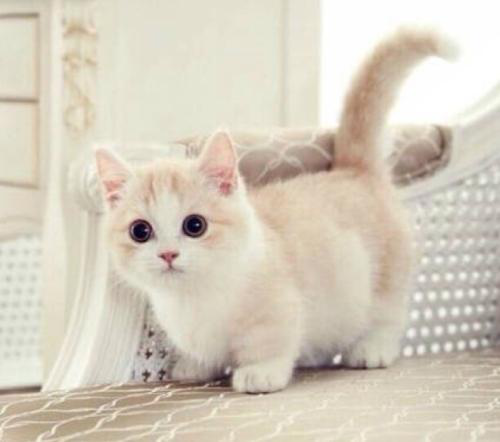

In [42]:
cat = Image.open(cat_image).convert('RGB')
cat

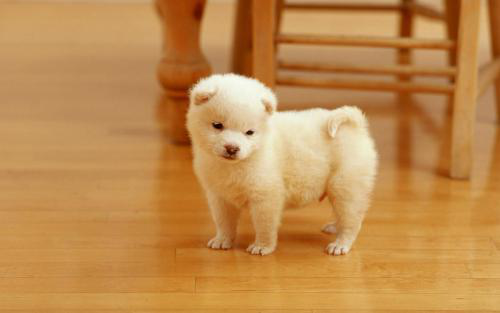

In [44]:
dog = Image.open(dog_image).convert('RGB')
dog

In [39]:
predict_model = VGG16(pretrained=False)
predict_model.classifier[6] = torch.nn.Linear(4096, 2)

In [57]:
predict_model.load_state_dict(torch.load(ckpt_path))
predict_model.cuda()
predict_model.eval()

img_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

cat_input = img_trans(cat).cuda()
dog_input = img_trans(dog).cuda()

# inputs = torch.stack([cat_input, dog_input], dim=0)
inputs = cat_input.unsqueeze(0)

with torch.no_grad():
    outputs = predict_model(inputs)
    print(outputs.argmax(dim=1, keepdim=False).item())

<class 'int'>
